# Rationale Model

### Hyperparameters

In [1]:
max_sentlen, max_doclen = 3, 2
word_dim, vocab_size = 5, 10
nb_filter, filter_len = 16, 1

nb_class = 2

Define an attention-specific layer...

In [2]:
import keras.backend as K

def sum_vectors(x):
    """Sums a batch of vectors
    
    Parameters
    ----------
    x : (nb_batch, max_textlen, nb_filter) tensor
    
    Sums `x` along `axis=1` and returns a (nb_batch, nb_filter) tensor.
    
    """
    return K.sum(x, axis=1)

Using Theano backend.


### Define Model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 6, 5)          50          input_1[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 3, 10)      0           embedding_1[0][0]                
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 3, 2)      96          reshape_1[0][0]                  
___________________________________________________________________________________________

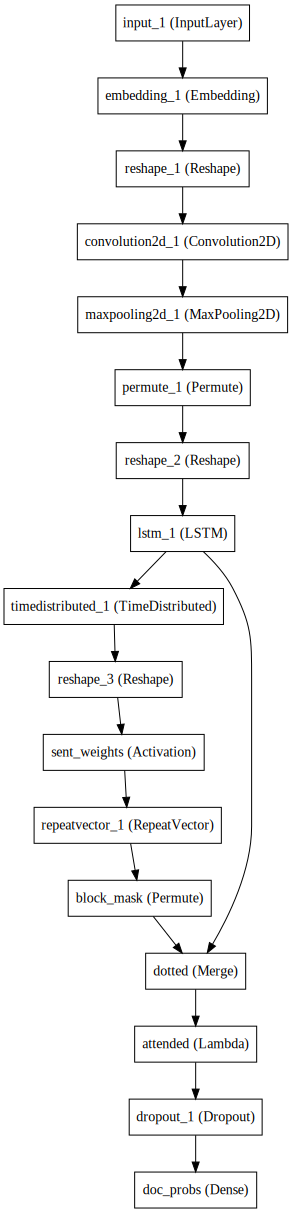

In [3]:
from keras.layers import Input, Embedding, Dense, Reshape, Permute, Dropout, merge
from keras.layers import Convolution2D, MaxPooling2D, Flatten, LSTM, AveragePooling1D
from keras.models import Model
from keras.layers import TimeDistributed, RepeatVector, Lambda
from keras.layers.core import Activation

# compute sentence vectors
input = Input(shape=[max_sentlen*max_doclen], dtype='int32')
embedded = Embedding(output_dim=word_dim, input_dim=vocab_size, input_length=max_sentlen*max_doclen)(input)
reshaped = Reshape([1, max_sentlen, word_dim*max_doclen])(embedded)
convolved = Convolution2D(nb_filter, nb_row=filter_len, nb_col=word_dim, subsample=[1, word_dim])(reshaped)
pooled = MaxPooling2D(pool_size=[max_sentlen-filter_len+1, 1])(convolved)
permuted = Permute([2, 3, 1])(pooled)
activations = Reshape([max_doclen, nb_filter])(permuted)
hiddens = LSTM(output_dim=nb_filter, return_sequences=True)(activations)

# compute attention mask
mask = TimeDistributed(Dense(1))(hiddens)
mask = Reshape([max_doclen])(mask)
mask = Activation('softmax', name='sent_weights')(mask)
mask = RepeatVector(nb_filter)(mask)
mask = Permute([2, 1], name='block_mask')(mask)

# apply attention mask
dotted = merge([hiddens, mask], mode='mul', name='dotted')
hidden = Lambda(function=sum_vectors, output_shape=[nb_filter], name='attended')(dotted)

hidden = Dropout(0.5)(hidden)
doc_probs = Dense(output_dim=nb_class, activation='softmax', name='doc_probs')(hidden)

model = Model(input=input, output=doc_probs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train Model

In [4]:
from keras.utils.np_utils import to_categorical

nb_train = 2

X = np.zeros([nb_train, max_sentlen*max_doclen])
X[0], X[1] = np.array([1, 2, 1] + [0, 1, 0]), np.array([0, 1, 0] + [1, 2, 1])

y = to_categorical([1, 0])

model.fit(X, y)

Epoch 1/10
2/2 [==============================] - 0s - loss: 0.6928 - acc: 0.5000
Epoch 2/10
2/2 [==============================] - 0s - loss: 0.6940 - acc: 0.5000
Epoch 3/10
2/2 [==============================] - 0s - loss: 0.6918 - acc: 1.0000
Epoch 4/10
2/2 [==============================] - 0s - loss: 0.6916 - acc: 1.0000
Epoch 5/10
2/2 [==============================] - 0s - loss: 0.6943 - acc: 0.5000
Epoch 6/10
2/2 [==============================] - 0s - loss: 0.6945 - acc: 0.5000
Epoch 7/10
2/2 [==============================] - 0s - loss: 0.6911 - acc: 0.5000
Epoch 8/10
2/2 [==============================] - 0s - loss: 0.6926 - acc: 1.0000
Epoch 9/10
2/2 [==============================] - 0s - loss: 0.6910 - acc: 1.0000
Epoch 10/10
2/2 [==============================] - 0s - loss: 0.6921 - acc: 1.0000


### Predict

In [5]:
import keras.backend as K

f = K.function(inputs=model.inputs+[K.learning_phase()],
               outputs=[model.get_layer('sent_weights').output, model.get_layer('doc_probs').output])

[output[0] for output in f([X, 1])] # only grab the result from the first document

[array([ 0.50035012,  0.49964991], dtype=float32),
 array([ 0.50062913,  0.4993709 ], dtype=float32)]